In [6]:
from datasets import load_dataset

# There is only one split on the hub
dataset = load_dataset("OGB/ogbg-molhiv")

dataset = dataset.shuffle(seed=0)


Found cached dataset json (/home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-1688f3a3aa9acbbd.arrow
Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-b117291977bf1456.arrow
Loading cached shuffled indices for dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-f08fb17f8a35b3d7.arrow


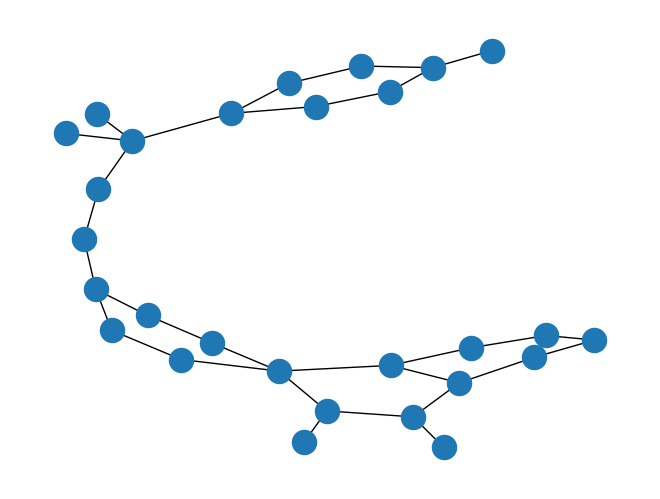

In [113]:
import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)


In [129]:
print(graph.keys())

dict_keys(['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'])


In [152]:
my_g = nx.Graph()
nodes = ['Korgan Bloodaxe', # 0
         'a tomb over in the lower crypts of the Graveyard District', # 1
         'Book of Kaza', # 2
         'location', # 3
         'character', # 4
         'object'] # 5
my_g.add_nodes_from(nodes)
my_g.add_edges_from([(nodes[1], nodes[3]), (nodes[2], nodes[0]), (nodes[2], nodes[1]), (nodes[2], nodes[5])])
my_g.add_edge(nodes[0], nodes[4], label='type of')

In [153]:
for i in my_g.adjacency():
    print(i)

('Korgan Bloodaxe', {'Book of Kaza': {}, 'character': {'label': 'type of'}})
('a tomb over in the lower crypts of the Graveyard District', {'location': {}, 'Book of Kaza': {}})
('Book of Kaza', {'Korgan Bloodaxe': {}, 'a tomb over in the lower crypts of the Graveyard District': {}, 'object': {}})
('location', {'a tomb over in the lower crypts of the Graveyard District': {}})
('character', {'Korgan Bloodaxe': {'label': 'type of'}})
('object', {'Book of Kaza': {}})


In [7]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)


Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-49407c506b7c3edb.arrow


Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-121409022ee691f7.arrow
Loading cached processed dataset at /home/manish/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-b34d0a7acd75a063.arrow


In [48]:
from transformers import GraphormerForGraphClassification

graphormer_model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=1, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)


In [49]:
import torch

class GATHead(torch.nn.Module):

    def __init__(self, graphormerModel):
        super(GATHead, self).__init__()

        self.graph_encoder = graphormerModel.graph_encoder
        self.lm_head_transform_weight = graphormerModel.lm_head_transform_weight

    def forward(self, x):
        x, graph_rep = self.graph_encoder(**x)
        x = x[-1].transpose(0, 1)
        x = self.lm_head_transform_weight(x)
        return x

graphormer_head = GATHead(graphormer_model.encoder)

In [50]:
graphormer_head

GATHead(
  (graph_encoder): GraphormerGraphEncoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (graph_node_feature): GraphormerGraphNodeFeature(
      (atom_encoder): Embedding(4609, 768, padding_idx=0)
      (in_degree_encoder): Embedding(512, 768, padding_idx=0)
      (out_degree_encoder): Embedding(512, 768, padding_idx=0)
      (graph_token): Embedding(1, 768)
    )
    (graph_attn_bias): GraphormerGraphAttnBias(
      (edge_encoder): Embedding(1537, 32, padding_idx=0)
      (edge_dis_encoder): Embedding(131072, 1)
      (spatial_pos_encoder): Embedding(512, 32, padding_idx=0)
      (graph_token_virtual_distance): Embedding(1, 32)
    )
    (emb_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x GraphormerGraphEncoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (activation_dropout_module): Dropout(p=0.1, inplace=False)
        (activation_fn): GELUActivation()
        (self_attn): Gr

In [51]:
collator = GraphormerDataCollator()
graph_data = collator([dataset_processed['validation'][0]])
graph_data.keys()

dict_keys(['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels'])

In [52]:
for k,v in graph_data.items():
    print(k, '\t', v.shape)

attn_bias 	 torch.Size([1, 48, 48])
attn_edge_type 	 torch.Size([1, 47, 47, 3])
spatial_pos 	 torch.Size([1, 47, 47])
in_degree 	 torch.Size([1, 47])
input_nodes 	 torch.Size([1, 47, 9])
input_edges 	 torch.Size([1, 47, 47, 22, 3])
out_degree 	 torch.Size([1, 47])
labels 	 torch.Size([1])


In [53]:
graph_data.pop('labels')
# data.pop('attn_bias')

tensor([0])

In [54]:
out = graphormer_head(graph_data)

torch.Size([1, 48, 768])
torch.Size([1, 48, 768])


In [11]:
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, BitsAndBytesConfig, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import networkx as nx

In [12]:
import os

base_dir = '/home/manish/thesis-implementations/quest_generation/llama2/'
model_name = 'meta-llama/llama-2-7b-hf'
model_dir = 'models'
model_path = os.path.join(base_dir, model_dir, model_name)

In [13]:
def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token
    
    return tokenizer

def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{12288}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        use_cache=False,
        device_map="auto",
        max_memory = {i: max_memory for i in range(n_gpus)},
    )

    return model, load_tokenizer(model_name)

In [14]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [55]:
# Load model from HF with user's token and with bitsandbytes config
bnb_config = create_bnb_config()
llama_model, llama_tokenizer = load_model(model_path, bnb_config)
# tokenizer = load_tokenizer(model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [71]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

In [72]:
llama_max_length = get_max_length(llama_model)

Found max lenth: 4096


In [67]:
graph_out_len = list(graphormer_head.children())[-1].out_features
llama_in_len = llama_model.config.hidden_size

In [74]:
torch.cat([torch.tensor([0, 1]), torch.tensor([0, 3])])

tensor([0, 1, 0, 3])

In [102]:
import torch

class KGLlama(torch.nn.Module):

    def __init__(self, graphEncoder, max_graph_tokens, llama):
        super(KGLlama, self).__init__()

        self.GraphEncoder = graphEncoder
        
        graph_out_len = list(graphormer_head.children())[-1].out_features        
        self.linear = torch.nn.Linear(graph_out_len, max_graph_tokens)
        self.llama = llama
        
    def forward(self, tokenized_prompt, kg):
        kg = self.GraphEncoder(kg)
        kg = self.linear(kg)
        # kg = torch.flatten(kg)
        
        # print(kg.size())
        # print(str(kg))
        
        # x = self.llama(tokenized_prompt)
        return kg

kg_llama_model = KGLlama(graphormer_head, 32, llama_model)

In [84]:
kg_llama_model

KGLlama(
  (GraphEncoder): GATHead(
    (graph_encoder): GraphormerGraphEncoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (graph_node_feature): GraphormerGraphNodeFeature(
        (atom_encoder): Embedding(4609, 768, padding_idx=0)
        (in_degree_encoder): Embedding(512, 768, padding_idx=0)
        (out_degree_encoder): Embedding(512, 768, padding_idx=0)
        (graph_token): Embedding(1, 768)
      )
      (graph_attn_bias): GraphormerGraphAttnBias(
        (edge_encoder): Embedding(1537, 32, padding_idx=0)
        (edge_dis_encoder): Embedding(131072, 1)
        (spatial_pos_encoder): Embedding(512, 32, padding_idx=0)
        (graph_token_virtual_distance): Embedding(1, 32)
      )
      (emb_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x GraphormerGraphEncoderLayer(
          (dropout_module): Dropout(p=0.0, inplace=False)
          (activation_dropout_module): Dropout(p=0.1, inplace=False)


In [91]:
encoded_text = llama_tokenizer.encode('Hello world!', return_tensors='pt')

In [110]:
graph_data['attn_bias'].shape

torch.Size([1, 48, 48])

In [103]:
out = kg_llama_model(encoded_text, graph_data)

torch.Size([1, 48, 768])
torch.Size([1, 48, 768])


In [107]:
out.shape

torch.Size([1, 48, 32])

In [105]:
torch.flatten(out).size()

torch.Size([1536])

In [61]:
decode = kg_llama_model.llama.generate(encoded_text)

/home/manish/miniconda3/envs/llama2/lib/python3.10/site-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [62]:
llama_tokenizer.decode(decode[0])

'<s> Hello world! Welcome to my new website. Hinweis: Der Artikel ist nicht mehr aktuell. Es gibt einen neuen Artikel über die Kategorie.\nWelcome to my new website. Hinweis: Der Artikel ist nicht mehr aktuell. Es gibt einen neuen Artikel über die Kategorie.</s>'